This notebook will showcase the solution for challenge 1.  
  
**This notebook will be as a stream of consciousness of my development process. I explore and develop as I go along, and will leave commentary of my thoughts. It will make it a bit on the extensive side, but there will be another (more concise) notebook as a deliverable that will have all the found insights to be presented to key stakeholders if needed.**  
  
I've chosen the "Italian power load" dataset, and what we need to know about it is:  
> *Your client is Zap Inc, a fictional power player in Italy.*  
> *They're handing you data on Italy's power load from 2006 to 2022.*  
> *Marta, your wise colleague, has a piece of advice for you: **be careful with 2020, it was a very peculiar year.***
  
And challenge 1 particularly reads:  
> *Zap Inc asks you for a complete report about the main feature of the power load series.*  
> *The report should be understandable by a layman, but it should also provide enough details to be useful for a data scientist.*  
> ***Create a Jupyter Notebook that sheds light on the main characteristics of the power load data.***  
> *Make it clear, make it insightful!*

# EDA

Lets first load our data and have a look around

In [1]:
import pandas as pd
power_load_df = pd.read_csv("../datasets/italian-power-load/load.csv")

In [2]:
power_load_df.shape

(5882, 2)

In [3]:
power_load_df.head()

,Date,Load
0,2006-01-01,666542.0
1,2006-01-02,855403.0
2,2006-01-03,914705.0
3,2006-01-04,926705.0
4,2006-01-05,927560.0


The dataset readme states that we only have two variables:  
- the date when the load is recorded  
- the load amount in MWh  

That does seem to be the case

In [4]:
power_load_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5882 entries, 0 to 5881
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    5882 non-null   object 
 1   Load    5882 non-null   float64
dtypes: float64(1), object(1)
memory usage: 92.0+ KB


It seems encouraging that there are no nulls

In [5]:
power_load_df.describe()

,Load
count,5.882000e+03
mean,8.494072e+05
std,1.257623e+05
min,4.587518e+05
25%,7.575872e+05
50%,8.720725e+05
75%,9.424057e+05
max,1.188554e+06


In [6]:
power_load_df.dtypes

Date     object
Load    float64
dtype: object

Our dates aren't being recognized as dates, we can fix that, it will benefit us in the future

In [7]:
power_load_df.Date = pd.to_datetime(power_load_df.Date)

In [8]:
power_load_df.describe()

,Date,Load
count,5882,5.882000e+03
mean,2014-01-19 12:00:00,8.494072e+05
min,2006-01-01 00:00:00,4.587518e+05
25%,2010-01-10 06:00:00,7.575872e+05
50%,2014-01-19 12:00:00,8.720725e+05
75%,2018-01-28 18:00:00,9.424057e+05
max,2022-02-07 00:00:00,1.188554e+06
std,NaN,1.257623e+05


We can see that we indeed have data from `2006-01-01` to `2022-02-07`  
The load distribution would perhaps be better analyzed through a graph. First we'll try a density plot, that will show us the frequency for which each wattage was recorded. We'll later look at other graphs. Line graphs are usally most informative in time series

<Axes: ylabel='Density'>

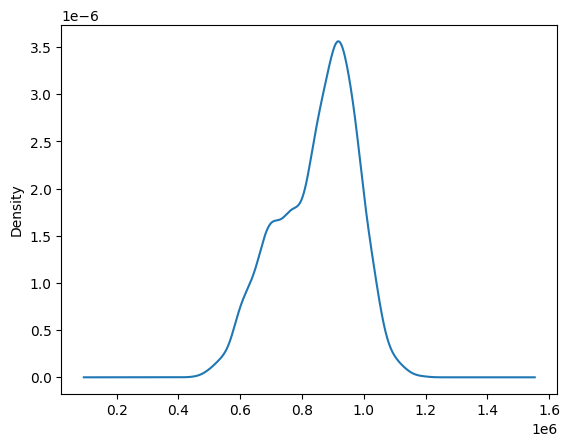

In [9]:
power_load_df.Load.plot.density()

It seems slightly left skewed. Due to Marta's warning, I'd like to look at this yearly, see if we notice any difference

Date
2006-12-31    Axes(0.125,0.11;0.775x0.77)
2007-12-31    Axes(0.125,0.11;0.775x0.77)
2008-12-31    Axes(0.125,0.11;0.775x0.77)
2009-12-31    Axes(0.125,0.11;0.775x0.77)
2010-12-31    Axes(0.125,0.11;0.775x0.77)
2011-12-31    Axes(0.125,0.11;0.775x0.77)
2012-12-31    Axes(0.125,0.11;0.775x0.77)
2013-12-31    Axes(0.125,0.11;0.775x0.77)
2014-12-31    Axes(0.125,0.11;0.775x0.77)
2015-12-31    Axes(0.125,0.11;0.775x0.77)
2016-12-31    Axes(0.125,0.11;0.775x0.77)
2017-12-31    Axes(0.125,0.11;0.775x0.77)
2018-12-31    Axes(0.125,0.11;0.775x0.77)
2019-12-31    Axes(0.125,0.11;0.775x0.77)
2020-12-31    Axes(0.125,0.11;0.775x0.77)
2021-12-31    Axes(0.125,0.11;0.775x0.77)
2022-12-31    Axes(0.125,0.11;0.775x0.77)
Freq: A-DEC, Name: Load, dtype: object

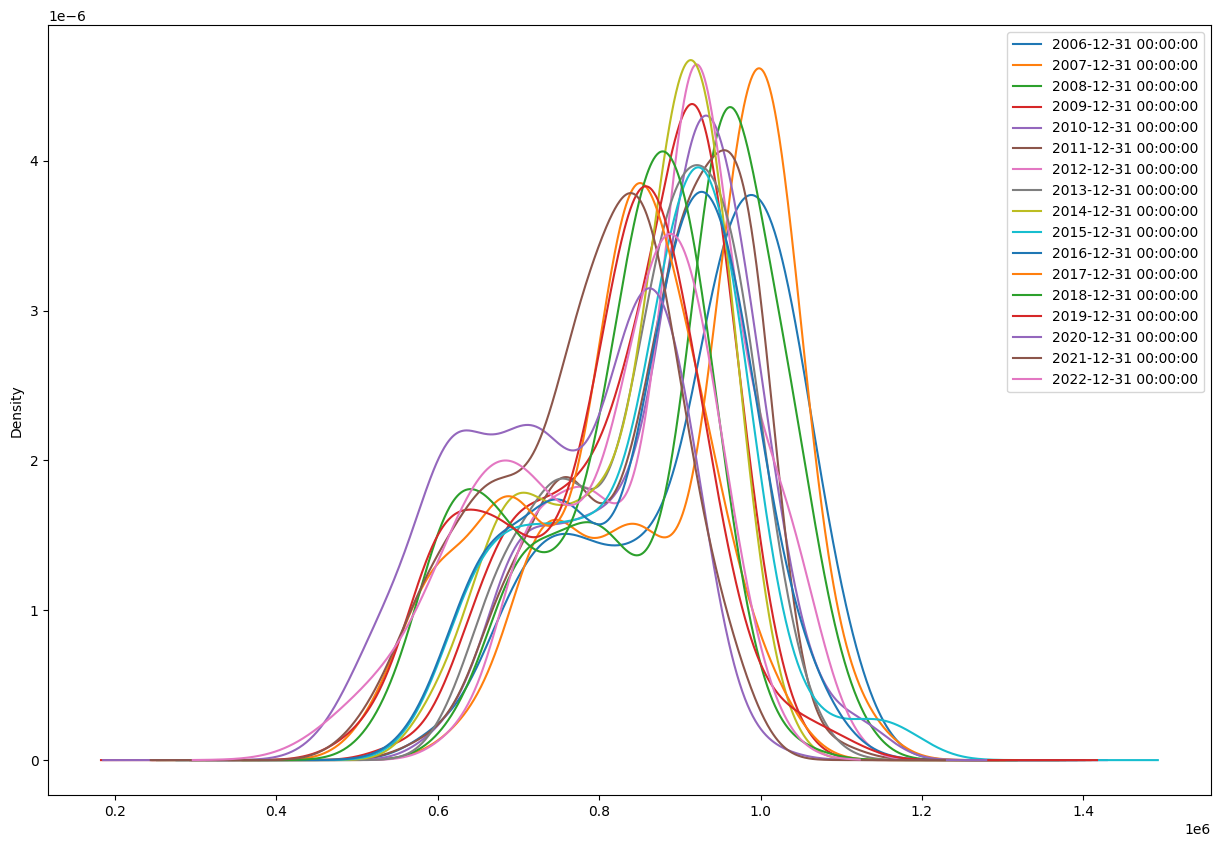

In [10]:
power_load_df.groupby(pd.Grouper(key='Date',freq='Y'))['Load'].plot(kind='density', legend=True, figsize=(15,10))

We see a lot of pretty colours, a bit confusing perhaps. I think I can see that 2020 may be the year whose lower wattage is a bit more frequent than the rest.  
Also, it seems that there is a group for which the peaks are a bit higher than the others, meaning those wattages (that are more on the high end) are more frequent, and so the consumption could bei higher that year.  
Let's isolate 2020

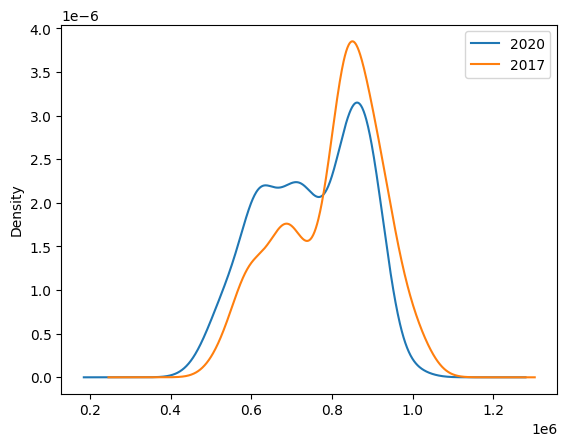

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
power_load_df.query("Date.dt.year==2020").Load.plot.density(legend=True)
power_load_df.query("Date.dt.year==2017").Load.plot.density(legend=True)
ax.legend(["2020", "2017"])

It does seem to be that one, so it is indeed a bit different than the rest. Lets remove 2020 and see if the overall density changes

<Axes: ylabel='Density'>

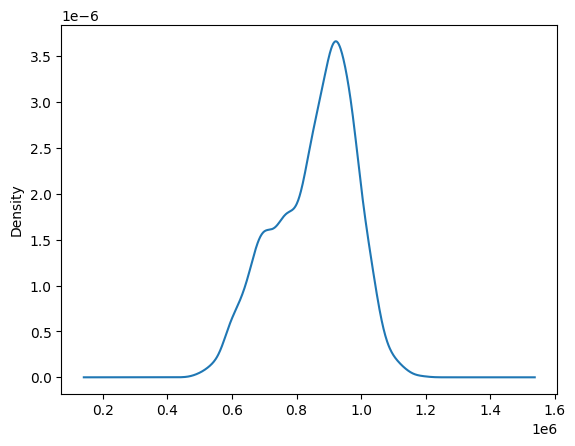

In [12]:
power_load_df.query("Date.dt.year!=2020").Load.plot.density()

Not much to be honest.  
Now, following the "high peaks" observation, lets sum up the loads by year and see what we get

<Axes: xlabel='Date'>

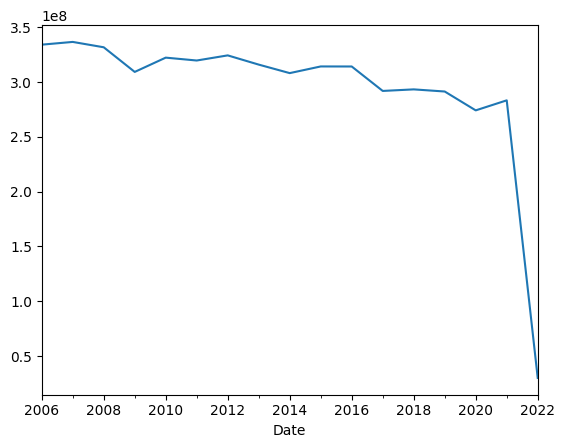

In [13]:
power_load_df.groupby(pd.Grouper(key='Date',freq='Y'))['Load'].sum().plot()

In [14]:
total_consumption_2019 = power_load_df.query("Date.dt.year==2019").Load.sum()
total_consumption_2006 = power_load_df.query("Date.dt.year==2006").Load.sum()
consumption_rate = total_consumption_2019/total_consumption_2006
print(f"The wattage consumption of 2019 was {consumption_rate:.2%} lower than that of 2006")

The wattage consumption of 2019 was 87.20% lower than that of 2006


It appears to have a slight downward trend, so Italians seem to be consuming less and less! (or at least on the high-voltage power 
infrastructure according to the dataset's README. That may mean something, we could check what kind of entities use this grid if we wanted to explore more)  
We can see a big dip in 2022 because the year is not yet complete so we can't compare it to the others.  
I think we should start looking at some line graphs now.

<Axes: xlabel='Date'>

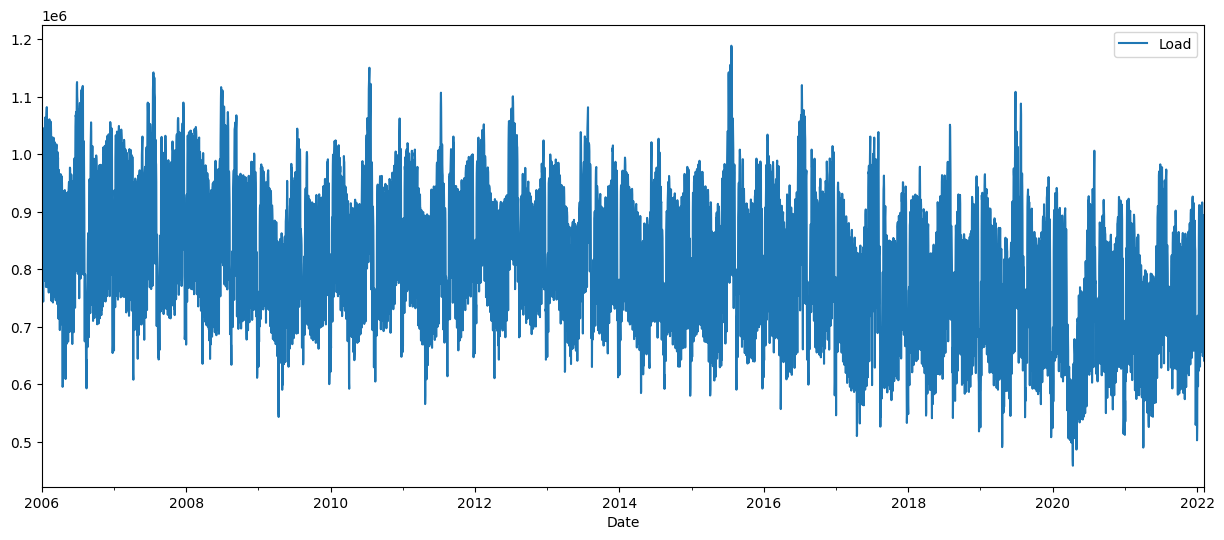

In [15]:
power_load_df.plot(x='Date',y='Load',kind='line',figsize=(15,6))

It does seem to be trending downards slightly, with continuous seasonal variations. And we see a noticeable dip in 2020! Confirms what Marta said, and what we saw on the density plot that lower wattages were more common that year

In [16]:
power_load_df['year'] = power_load_df.Date.dt.year
power_load_df['month_name'] = power_load_df.Date.dt.month_name()
power_load_df['day_of_year'] = power_load_df.Date.dt.day_of_year

/Users/francoferrero/anaconda3/envs/xtream/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/francoferrero/anaconda3/envs/xtream/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


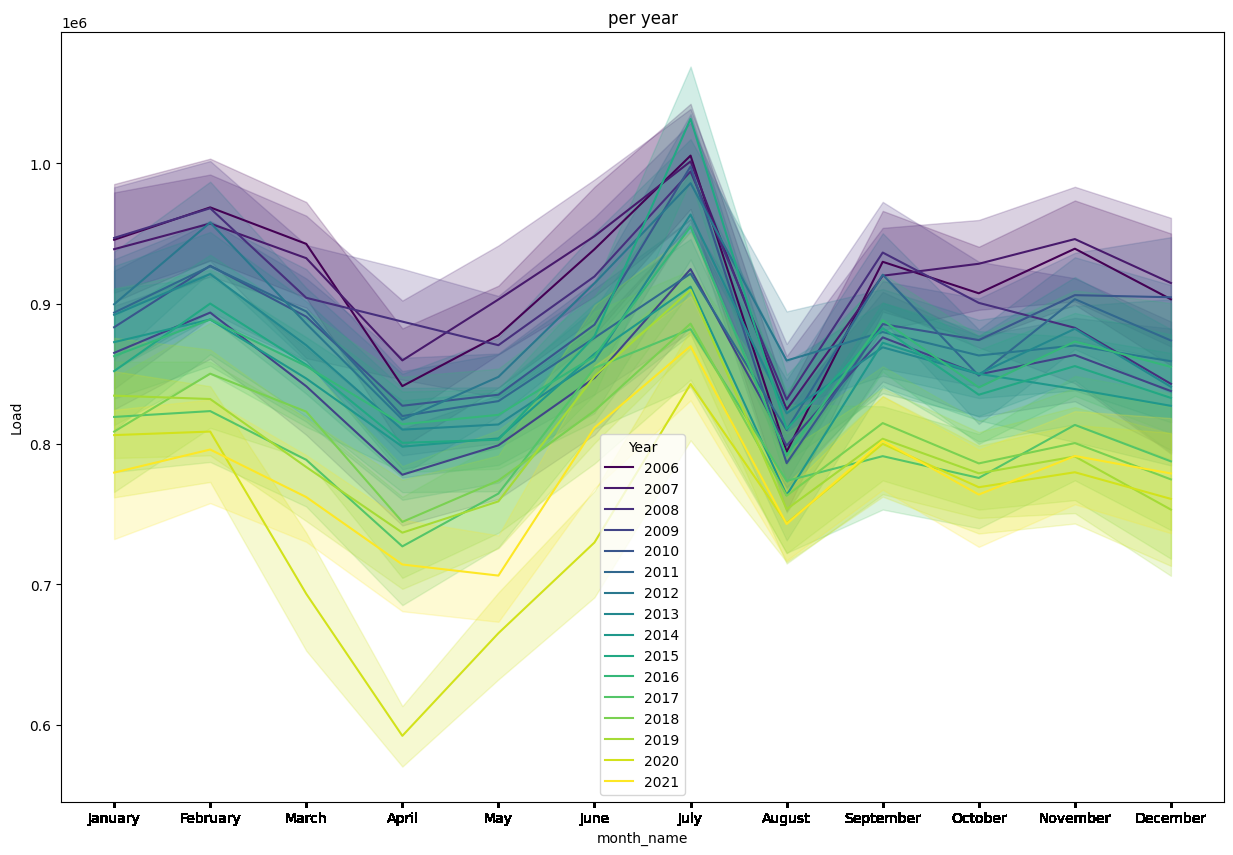

In [17]:
import seaborn as sns
ax = sns.lineplot(data=power_load_df.query("year<2022"), x='month_name', y='Load',
                  hue='year', palette='viridis')
ax.figure.set_size_inches(15, 10)
ax.set_xticks(power_load_df.month_name)
ax.set_title('per year')
ax.legend(ax.lines, power_load_df.query("year<2022").year.unique(), title='Year')
# plt.legend(loc='right')
plt.show()


Its a bit messy, but we see they follow seasonal variations as we knew, and that 2020 has that really big dip in march-april-may. Which is likely to be due to pandemic lockdowns, as they happened around the world.  
Lets look at just a couple of years to more closely observe seasonality

year
2016    Axes(0.125,0.11;0.775x0.77)
2017    Axes(0.125,0.11;0.775x0.77)
2018    Axes(0.125,0.11;0.775x0.77)
dtype: object

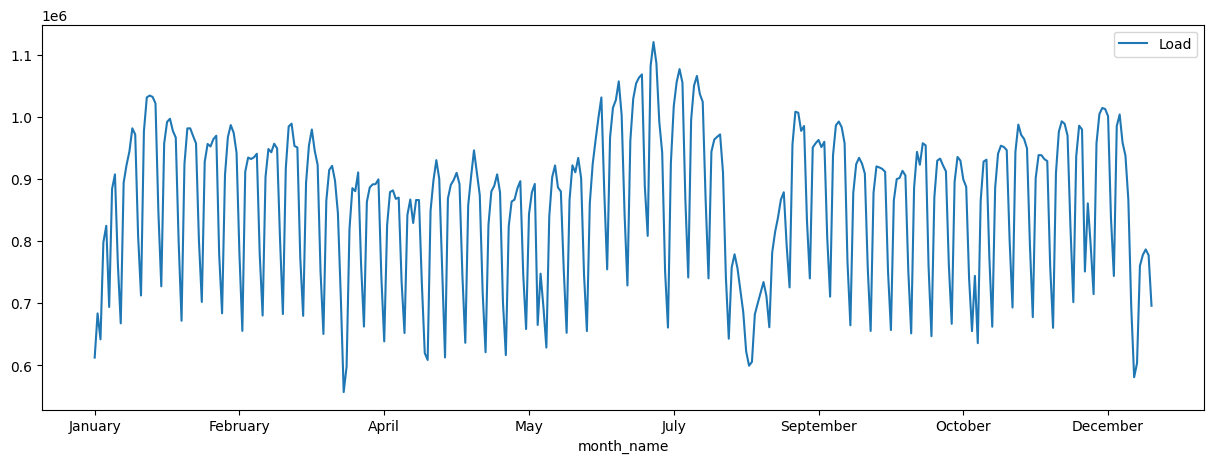

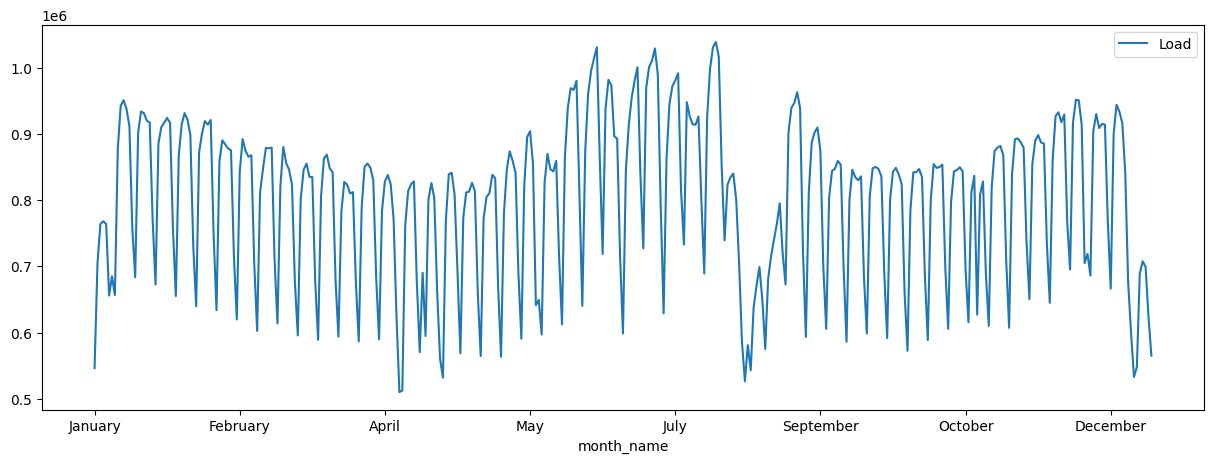

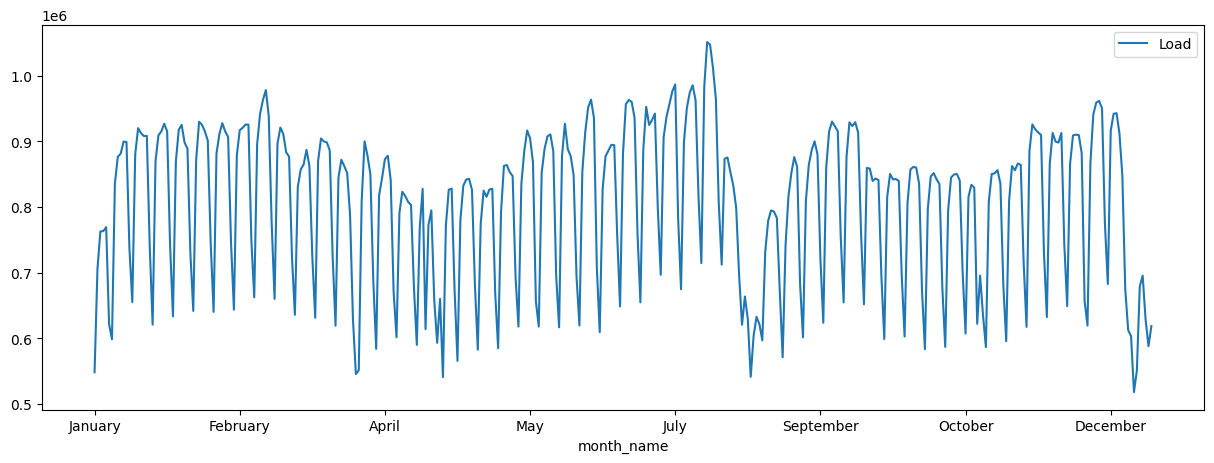

In [18]:
power_load_df.query("year>=2016 and year<=2018").groupby([power_load_df.year]).plot(x='month_name',y='Load',figsize=(15,5), kind='line')

First thing that comes to mind is that there are some worrying dips at the start and end of the year, and around August. I would think there is either some faulty data, or things seriously stop consuming energy in specific dates (at least in this speficic grid, are there others that could supply the remainder?)  
We could perhaps think on christmas and new years having most things closed since everyone is spending time with family and not working. Doing some googling I found that August 15 is an important holiday in Italy as well (ferragosto). But I'm not sure if those holidays are enough to explain such distinct drops. I would like to contact an SME at this point and ask about it.  
  
The other thing we can see is the change of the seasons.  
Winter (December to February) seems somewhat stable, I would guess here most people are using gas as well as electricity to heat up their homes.  
Spring (March to May) sees a decrease, there is less need for climate control when the weather is pleasant.  
Summer (June to August) sees an upward trend and the peak consumption of the year. We can only cool our homes with electricity, and so everyone turns on air conditioning and consumes more, so it makes sense.  
Autumn (September to November) again sees low-ish levels as climate is again fair.

In [19]:
power_load_df['day_of_week'] = power_load_df.Date.dt.day_of_week
power_load_df['day'] = power_load_df.Date.dt.day
power_load_df['month'] = power_load_df.Date.dt.month

In [21]:
power_load_without_2020_2022_df = power_load_df.query("not year.isin([2020,2022])").copy()

In [22]:
mean_daily_loads_by_month = power_load_without_2020_2022_df.groupby(['month_name','day']).Load.mean().reset_index()

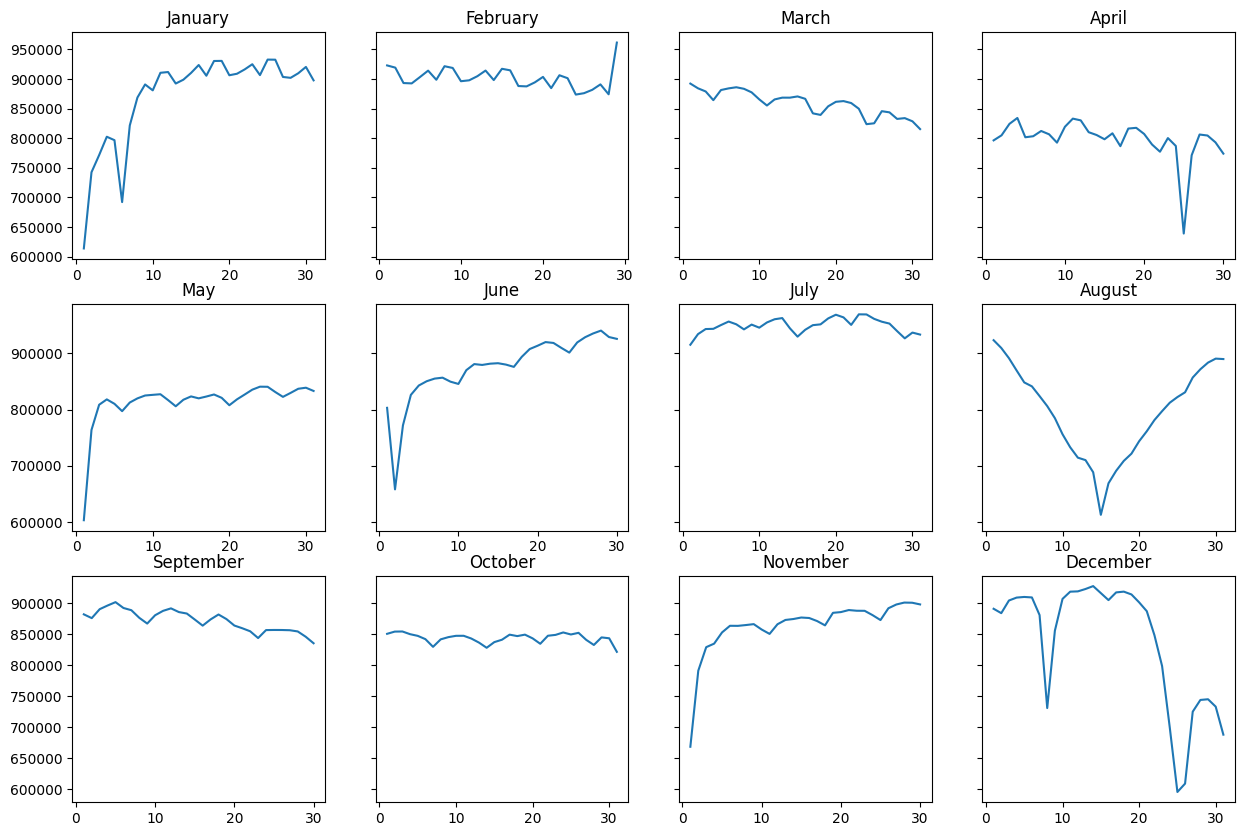

In [23]:
import matplotlib.pyplot as plt 
import numpy as np

figure, axis = plt.subplots(3, 4, sharey='row')
figure.set_size_inches(15,10)
axi = {
    0:(0,0),1:(0,1),2:(0,2),3:(0,3),
    4:(1,0),5:(1,1),6:(1,2),7:(1,3),
    8:(2,0),9:(2,1),10:(2,2),11:(2,3)
} 
for month_nbr, month_name in enumerate(power_load_df.month_name.unique()):
    axis[axi[month_nbr]].plot(
        mean_daily_loads_by_month.query("month_name==@month_name").day,
        mean_daily_loads_by_month.query("month_name==@month_name").Load,
        # kind='line',
        # legend=False,
    ) 
    axis[axi[month_nbr]].set_title(month_name)
    axis[axi[month_nbr]].ylim=(500000,1200000)



There isn't much new here when zooming into the months and using the mean of all years to get a general sense, we see the same seasonal trends we did, but we get a better sense of the days the dips occur, which if we look up an [Italian holiday's calendar](https://en.wikipedia.org/wiki/Public_holidays_in_Italy), they match up pretty nicely  
- January 1st (and shared with December 31st) -> Capodanno  
- January 6th -> Epifania
- April 25th -> Festa della Liberazione
- May 1st -> Festa del Lavoro
- June 2nd -> Festa della Repubblica
- August 15th -> Assunzione(Ferragosto)
- November 1st -> Tutti i santi
- December 8th -> Immacolata Concezione
- December 25th -> Natale

In [24]:
power_load_without_2020_2022_df['day_of_week_name'] = power_load_without_2020_2022_df.Date.dt.day_name()
mean_daily_loads_by_week = power_load_without_2020_2022_df.groupby(['day_of_week','day_of_week_name']).Load.mean().reset_index()

<Axes: xlabel='day_of_week_name'>

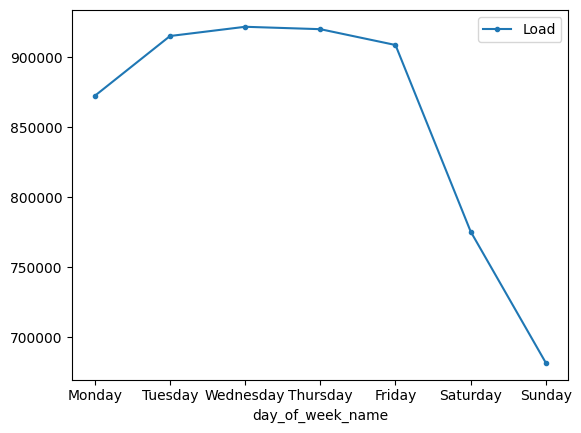

In [28]:
mean_daily_loads_by_week.plot(x='day_of_week_name',y='Load',style='.-')

This is the general weekly trend throughout the year, that is what makes al the zigzags in our previous line plots, 

<Axes: xlabel='day_of_week_name'>

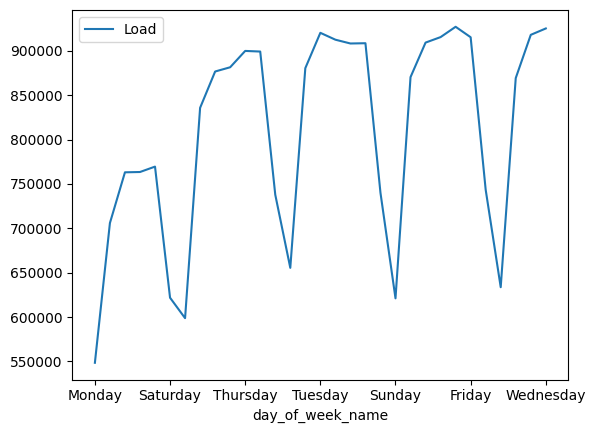

In [29]:
power_load_without_2020_2022_df.query("year==2018 and month==1").plot(x='day_of_week_name',y='Load')

Let's decompose the series

In [32]:
power_load_to_decompose = power_load_df.drop(columns=['year','month_name','day_of_year','day_of_week','day','month']).copy()

In [33]:
power_load_to_decompose.set_index('Date',inplace=True)

In [34]:
power_load_to_decompose.head()

,Load
Date,
2006-01-01,666542.0
2006-01-02,855403.0
2006-01-03,914705.0
2006-01-04,926705.0
2006-01-05,927560.0


In [52]:
from statsmodels.tsa.seasonal import MSTL

mstl = MSTL(power_load_to_decompose)
res = mstl.fit() 

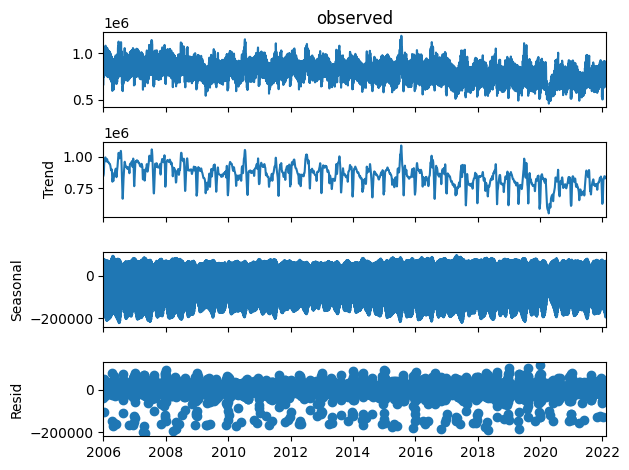

In [53]:
res.plot()
plt.tight_layout()
plt.show()

First is the complete time series, the second graph shows the trend, which is downward, the third finds the weekly seasonality which is very compressed, and the fourth are the residues, which if it was correctly decompose, should be random and not form any patterns.  
We can check a single year to see if we can see better since most have around the same behaviour

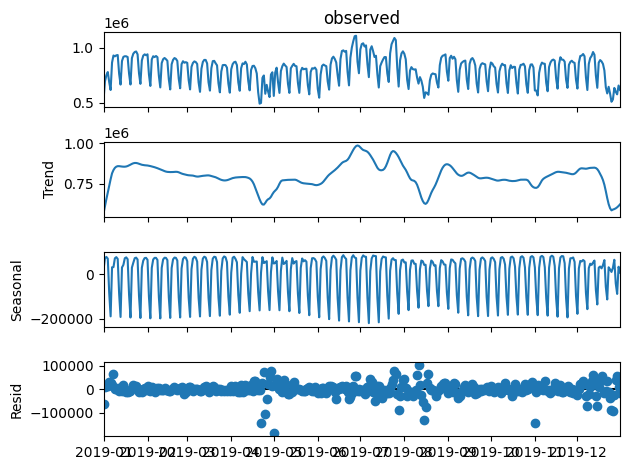

In [54]:
mstl = MSTL(power_load_to_decompose[power_load_to_decompose.index.year==2019])
res = mstl.fit() 
res.plot()
plt.tight_layout()
plt.show()